In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.feature_selection import mutual_info_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as  mse
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional,Conv1D, MaxPooling1D, Flatten, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from scikeras.wrappers import KerasRegressor
import joblib
from scipy.stats import uniform
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score  

In [2]:
df = pd.read_csv('Volve P-12_DatesCorrected.txt',index_col=0, parse_dates = True)

In [3]:
df.head()

,onstreaminject_HRS,BORE_WI_VOL,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P in percentage,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL
2007-01-09,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-01-10,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-01-11,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-01-12,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-01-13,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.columns

Index(['onstreaminject_HRS', 'BORE_WI_VOL', 'ON_STREAM_HRS',
       'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING',
       'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P in percentage', 'AVG_WHP_P',
       'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_GAS_VOL',
       'BORE_WAT_VOL'],
      dtype='object')

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

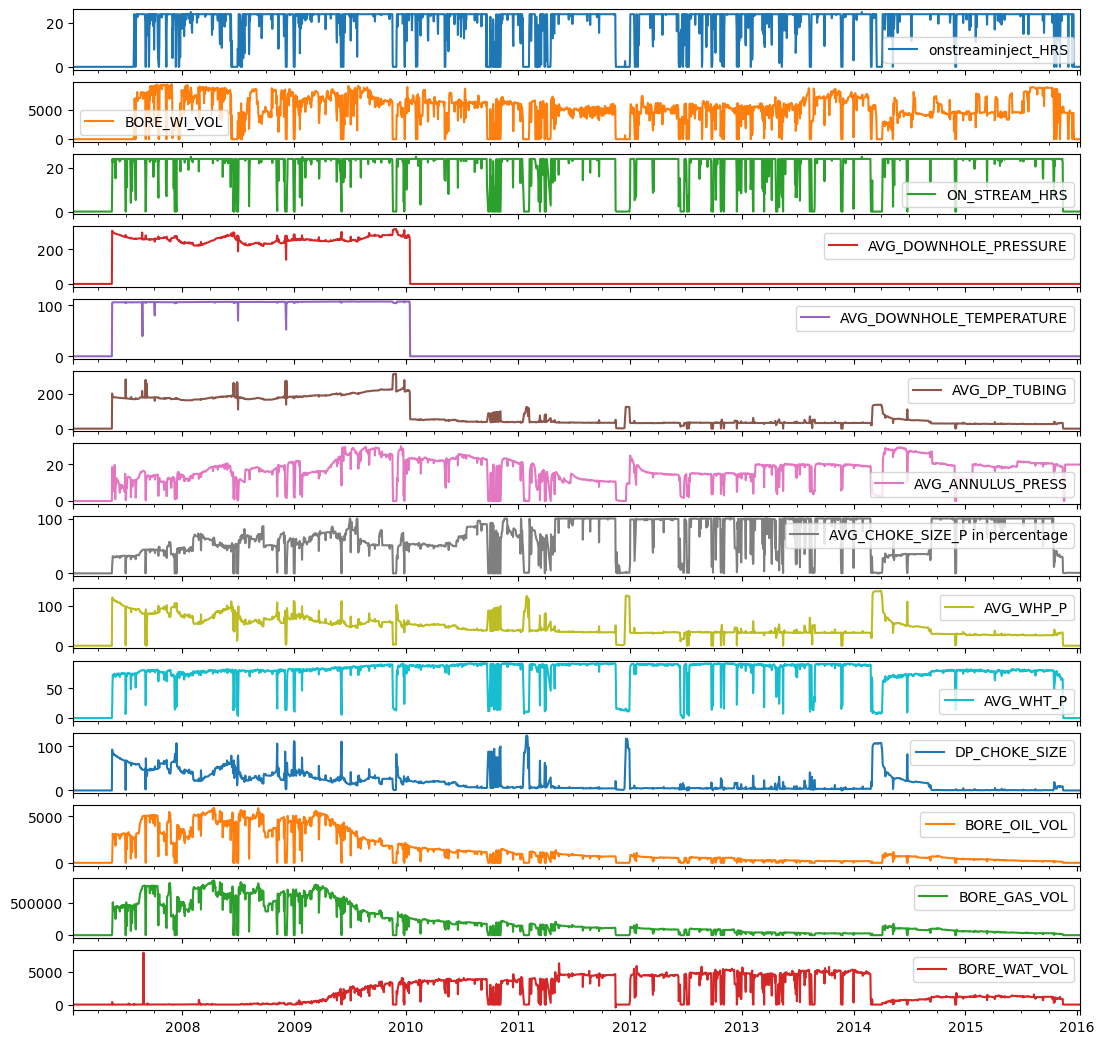

In [5]:
df.plot(subplots=True, figsize=(13,13))

In [27]:
target = 'BORE_OIL_VOL'

X=df.copy()
y=X.pop(target)

In [28]:
# train_length = int(len(df) * 0.8)

# X_train , y_train = X.iloc[:train_length,:] , y[:train_length]

# X_test , y_test = X.iloc[train_length:, :] , y[train_length:]

train_length = int(len(df) * 0.7)
test_length = int(len(df) * 0.15)

X_train , y_train = X.iloc[:train_length,:] , y[:train_length]

X_val , y_val = X.iloc[train_length:-test_length, :] , y[train_length:-test_length]

X_test , y_test = X.iloc[-test_length:, :] , y[-test_length:]



X_train.shape , y_train.shape, X_val.shape , y_val.shape, X_test.shape , y_test.shape, df.shape

((2303, 13), (2303,), (495, 13), (495,), (493, 13), (493,), (3291, 14))

In [29]:
train_data = df.iloc[:train_length,:]
train_data.corr()[target].sort_values(ascending=False)

BORE_OIL_VOL                      1.000000
BORE_GAS_VOL                      0.998390
AVG_DOWNHOLE_TEMPERATURE          0.819232
AVG_DOWNHOLE_PRESSURE             0.782062
AVG_DP_TUBING                     0.745388
AVG_WHP_P                         0.568955
BORE_WI_VOL                       0.503760
ON_STREAM_HRS                     0.471163
DP_CHOKE_SIZE                     0.430642
AVG_ANNULUS_PRESS                 0.342764
onstreaminject_HRS                0.300848
AVG_WHT_P                         0.273894
AVG_CHOKE_SIZE_P in percentage    0.025795
BORE_WAT_VOL                     -0.492249
Name: BORE_OIL_VOL, dtype: float64

using BORE_GAS_VOL as a feature could lead to overfitting                    

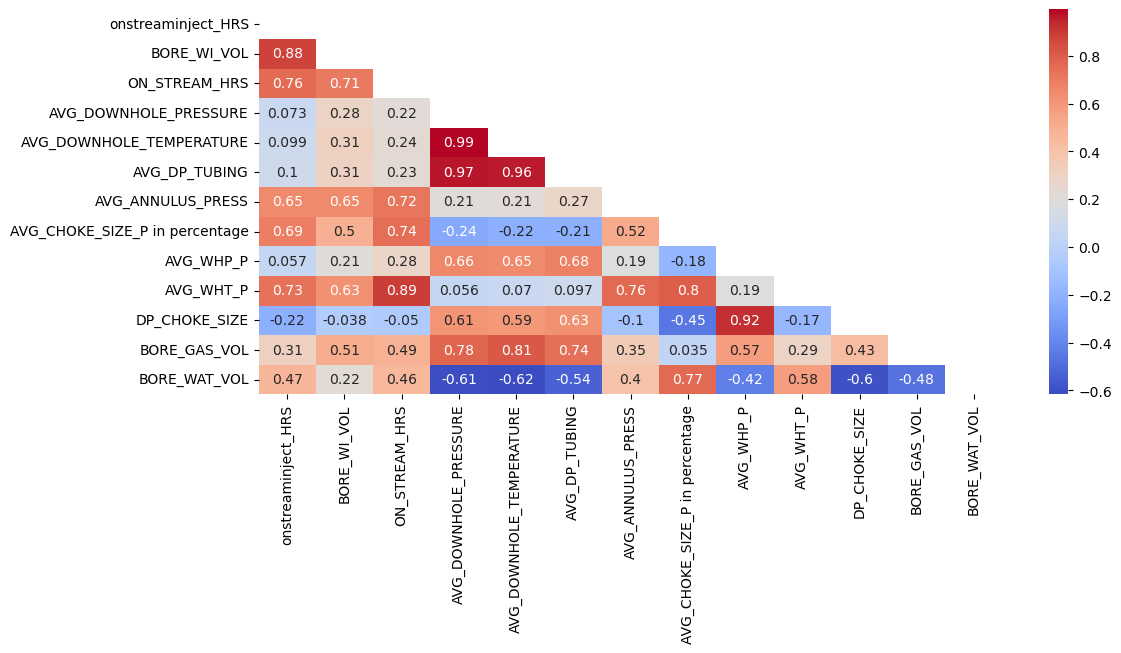

In [30]:
mask = np.zeros_like(X_train.corr())
mask[np.triu_indices_from(mask)] = True
# cmap=plt.cm.CMRmap_r
plt.figure(figsize=(12,5))
sns.heatmap(X_train.corr(), mask = mask, annot =True, cmap = 'coolwarm');

In [31]:
def correlation(dataset, threshold):
    # Calculate the correlation matrix
    corr_matrix = dataset.corr().abs()
    
    # Create a set to store the highly correlated features
    correlated_features = set()
    pairs =[]
    
    # Find pairs of features with high correlation
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] > threshold:
                # Add one of the features to the set
                feature1 = corr_matrix.columns[i]
                feature2 = corr_matrix.columns[j]
                correlated_features.add(feature1)
                pairs.append((feature1,feature2))
    
    # Return the set of highly correlated features
    return correlated_features, pairs

In [32]:
corr_features,pairs = correlation(X_train, 0.9)
len(corr_features)

3

In [33]:
corr_features

{'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'DP_CHOKE_SIZE'}

In [34]:
pairs

[('AVG_DOWNHOLE_TEMPERATURE', 'AVG_DOWNHOLE_PRESSURE'),
 ('AVG_DP_TUBING', 'AVG_DOWNHOLE_PRESSURE'),
 ('AVG_DP_TUBING', 'AVG_DOWNHOLE_TEMPERATURE'),
 ('DP_CHOKE_SIZE', 'AVG_WHP_P')]

In [35]:
X_train=X_train.drop('BORE_GAS_VOL', axis =1 )
X_train=X_train.drop(corr_features, axis=1)

In [36]:
X_val=X_val.drop('BORE_GAS_VOL', axis =1 )
X_val=X_val.drop(corr_features, axis=1)


X_test=X_test.drop('BORE_GAS_VOL', axis =1 )
X_test=X_test.drop(corr_features, axis=1)

In [37]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [38]:
mi_scores = make_mi_scores(X_train, y_train)
mi_scores

AVG_WHP_P                         1.739073
AVG_CHOKE_SIZE_P in percentage    1.728326
BORE_WAT_VOL                      1.519784
AVG_ANNULUS_PRESS                 1.499025
AVG_WHT_P                         1.157577
AVG_DOWNHOLE_PRESSURE             0.997532
BORE_WI_VOL                       0.867014
ON_STREAM_HRS                     0.486991
onstreaminject_HRS                0.261141
Name: MI Scores, dtype: float64

In [39]:
low_score = mi_scores[mi_scores<0.5].index

X_train = X_train.drop(low_score, axis=1)
X_test  = X_test.drop(low_score, axis=1)
X_val  = X_val.drop(low_score, axis=1)

In [40]:
# Scale the data using a MinMaxScaler
input_scaler = StandardScaler()
target_scaler = StandardScaler()

train_X_scaled = input_scaler.fit_transform(X_train)
train_y_scaled = target_scaler.fit_transform(y_train.values.reshape(-1,1)) #reshaped cos scaler obj accepts only 2d

val_X_scaled = input_scaler.transform(X_val)
val_y_scaled = target_scaler.transform(y_val.values.reshape(-1,1))

test_X_scaled = input_scaler.transform(X_test)
test_y_scaled = target_scaler.transform(y_test.values.reshape(-1,1))

In [41]:
def create_sequences(X_scaled, y_scaled, window_size, output_size):
    X_seq = []
    y_seq = []
    for i in range(window_size, len(X_scaled)):
        X_seq.append(X_scaled[i-window_size:i, :])
        y_seq.append(y_scaled[i:i+output_size, 0])
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)
    return X_seq, y_seq



n_in = 5
n_out = 1


X_train_lstm, y_train_lstm = create_sequences(train_X_scaled, train_y_scaled,n_in, n_out)


X_val_lstm, y_val_lstm = create_sequences(val_X_scaled,val_y_scaled, n_in, n_out)


X_test_lstm, y_test_lstm = create_sequences(test_X_scaled,test_y_scaled, n_in, n_out)


In [42]:
X_train_lstm.shape, X_val_lstm.shape, X_test_lstm.shape, y_test.shape, y_test_lstm.shape

((2298, 5, 7), (490, 5, 7), (488, 5, 7), (493,), (488, 1))

In [95]:
# # Set random seed
# random_seed = 60
# tf.random.set_seed(random_seed)

# # Define the create_model function with hyperparameters as arguments
# def create_model(neurons=64, dense_units=55):
#     model = Sequential()
#     model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2])))
#     model.add(Dense(dense_units))
#     model.add(Dense(1))
#     model.compile(optimizer='adam', loss='mse')
#     return model

# # Create a KerasRegressor based on the create_model function
# model = KerasRegressor(build_fn=create_model, verbose=0)

# # Define hyperparameters and their possible values for random search
# param_dist = {
#     'neurons': [32, 64, 128],
#     'dense_units': [32, 55, 128],
#     'epochs': [50, 100, 150],
#     'batch_size': [16, 32, 64]
# }

# # Create a TimeSeriesSplit instance
# tscv = TimeSeriesSplit(n_splits=3)

# # Create a RandomizedSearchCV instance with TimeSeriesSplit as cv
# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=tscv, random_state=random_seed)

# # Perform the random search
# random_search_result = random_search.fit(X_train_lstm, y_train_lstm)

# # Get the best model from the random search
# best_model = random_search_result.best_estimator_.model

# # Evaluate the best model on the validation data
# validation_loss = best_model.evaluate(X_val_lstm, y_val_lstm, verbose=0)

# # Print the best parameters, training score, and validation loss
# print("Best training score: %f" % random_search_result.best_score_)
# print("Validation loss: %f" % validation_loss)
# print("Best parameters: ", random_search_result.best_params_)


In [44]:
n_in = 5
n_out = 1

random_seed = 60
tf.random.set_seed(random_seed)

while True:
    
    lstm_model = Sequential()
    lstm_model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    lstm_model.add(Dense(55))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


    history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=100, validation_data=(X_val_lstm, y_val_lstm),
                        callbacks=[early_stopping], batch_size=20, verbose=0)


    yp_test_lstm = lstm_model.predict(X_test_lstm)
    yp_test_lstm = target_scaler.inverse_transform(yp_test_lstm)
    y_test = target_scaler.inverse_transform(y_test_lstm)


    rmse_score = mse(yp_test_lstm, y_test,squared=False)

    print(f"RMSE score: {rmse_score}")

    # Check if RMSE is less than 200, if yes, break the loop
    if rmse_score < 200:
        break

print("Training completed with RMSE < 200.")


16/16 [==============================] - 1s 9ms/step
RMSE score: 562.1889440433433
16/16 [==============================] - 1s 8ms/step
RMSE score: 173.67042855831005
Training completed with RMSE < 200.


In [45]:
yp_train = lstm_model.predict(X_train_lstm)
yp_train = target_scaler.inverse_transform(yp_train)


yp_test = lstm_model.predict(X_test_lstm)
yp_test = target_scaler.inverse_transform(yp_test)


yp_val = lstm_model.predict(X_val_lstm)
yp_val = target_scaler.inverse_transform(yp_val)



y_train_unscaled = target_scaler.inverse_transform(y_train_lstm)
y_test_unscaled = target_scaler.inverse_transform(y_test_lstm)
y_val_unscaled = target_scaler.inverse_transform(y_val_lstm)


16/16 [==============================] - 0s 7ms/step


In [46]:
lookback=n_in

adjusted_train_index=df.iloc[lookback:train_length].index
adjusted_val_index=df.iloc[train_length+lookback:-test_length:].index
adjusted_test_index=df.iloc[-test_length+lookback:].index

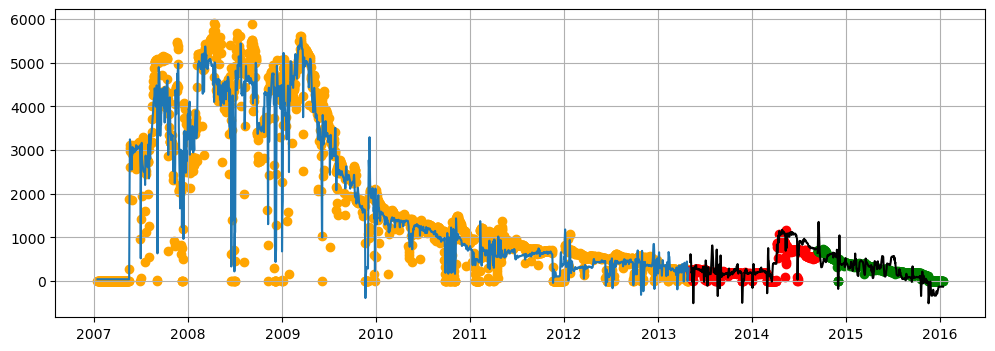

In [47]:
plt.figure(figsize=(12,4))

plt.scatter(adjusted_train_index , y_train_unscaled, color='orange')
plt.plot(adjusted_train_index , yp_train)

# plt.scatter(df.index[train_length+n_in:] , y_test, color='green')
# plt.plot(df.index[train_length+n_in:] , yp_test, color='black')

plt.scatter(adjusted_val_index, y_val_unscaled, color='red')
plt.plot(adjusted_val_index , yp_val, color='black')


plt.scatter(adjusted_test_index , y_test_unscaled, color='green')
plt.plot(adjusted_test_index , yp_test, color='black')

# plt.axvline(df.index[train_length+n_in], color='red')


plt.grid()

In [48]:
joblib.dump(lstm_model, 'lstm_model_best.joblib')

INFO:tensorflow:Assets written to: C:\Users\abdul\AppData\Local\Temp\tmp3q39qnnq\assets


INFO:tensorflow:Assets written to: C:\Users\abdul\AppData\Local\Temp\tmp3q39qnnq\assets


['lstm_model_best.joblib']

In [49]:
lstm_model = joblib.load('lstm_model_best.joblib')

In [50]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                18432     
                                                                 
 dense_4 (Dense)             (None, 55)                3575      
                                                                 
 dense_5 (Dense)             (None, 1)                 56        
                                                                 
Total params: 22063 (86.18 KB)
Trainable params: 22063 (86.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### 

### CNN

In [20]:
df2=df.copy()

df2=df2.drop('BORE_GAS_VOL', axis =1 )
df2=df2.drop(corr_features, axis=1)
df2=df2.drop(low_score, axis=1)


In [157]:
n_in = 5
n_out = 1


X_train_cnn, y_train_cnn = create_sequences(train_X_scaled, train_y_scaled,n_in, n_out)


X_val_cnn, y_val_cnn = create_sequences(val_X_scaled,val_y_scaled, n_in, n_out)


X_test_cnn, y_test_cnn = create_sequences(test_X_scaled,test_y_scaled, n_in, n_out)

Epoch 1/100
115/115 [==============================] - 2s 7ms/step - loss: 0.2137 - val_loss: 0.0750
Epoch 2/100
115/115 [==============================] - 0s 4ms/step - loss: 0.1297 - val_loss: 0.0568
Epoch 3/100
115/115 [==============================] - 0s 4ms/step - loss: 0.1192 - val_loss: 0.0565
Epoch 4/100
115/115 [==============================] - 1s 6ms/step - loss: 0.1092 - val_loss: 0.0397
Epoch 5/100
115/115 [==============================] - 1s 8ms/step - loss: 0.1064 - val_loss: 0.0621
Epoch 6/100
115/115 [==============================] - 1s 7ms/step - loss: 0.1022 - val_loss: 0.0446
Epoch 7/100
115/115 [==============================] - 1s 7ms/step - loss: 0.0962 - val_loss: 0.0323
Epoch 8/100
115/115 [==============================] - 1s 8ms/step - loss: 0.1015 - val_loss: 0.0484
Epoch 9/100
115/115 [==============================] - 1s 6ms/step - loss: 0.0905 - val_loss: 0.0395
Epoch 10/100
115/115 [==============================] - 1s 6ms/step - loss: 0.0916 - val_lo

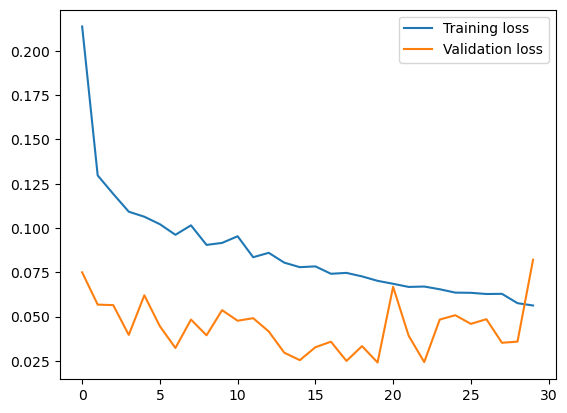

In [167]:
np.random.seed(60)
tf.random.set_seed(60)
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
# cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(25, activation='relu'))
# cnn_model.add(Dense(55, activation='relu'))
cnn_model.add(Dense(1))

# compile the model
cnn_model.compile(loss='mse', optimizer='adam')

# early_stopping = EarlyStopping(monitor='val_loss', patience = 10)
early_stopping = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights=True)

history = cnn_model.fit(X_train_cnn, y_train_cnn, epochs=100,validation_data=(X_val_cnn,y_val_cnn),callbacks=[early_stopping], batch_size=20)
# history = cnn_model.fit(X_train, y_train, epochs=5, batch_size=64)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [168]:
yp_train = cnn_model.predict(X_train_cnn)
yp_train = target_scaler.inverse_transform(yp_train)


yp_test = cnn_model.predict(X_test_cnn)
yp_test = target_scaler.inverse_transform(yp_test)


yp_val = cnn_model.predict(X_val_cnn)
yp_val = target_scaler.inverse_transform(yp_val)



y_train_unscaled = target_scaler.inverse_transform(y_train_cnn)
y_test_unscaled = target_scaler.inverse_transform(y_test_cnn)
y_val_unscaled = target_scaler.inverse_transform(y_val_cnn)

16/16 [==============================] - 0s 3ms/step


In [169]:
lookback=n_in

adjusted_train_index=df.iloc[lookback:train_length].index
adjusted_val_index=df.iloc[train_length+lookback:-test_length:].index
adjusted_test_index=df.iloc[-test_length+lookback:].index

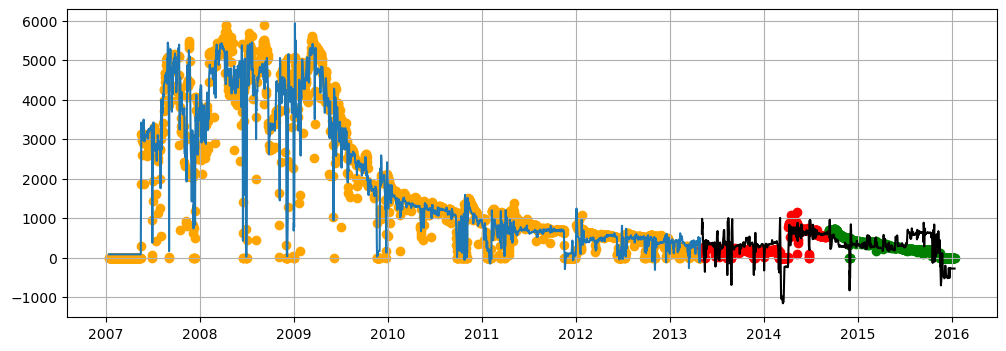

In [170]:
plt.figure(figsize=(12,4))

plt.scatter(adjusted_train_index , y_train_unscaled, color='orange')
plt.plot(adjusted_train_index , yp_train)

# plt.scatter(df.index[train_length+n_in:] , y_test, color='green')
# plt.plot(df.index[train_length+n_in:] , yp_test, color='black')

plt.scatter(adjusted_val_index, y_val_unscaled, color='red')
plt.plot(adjusted_val_index , yp_val, color='black')


plt.scatter(adjusted_test_index , y_test_unscaled, color='green')
plt.plot(adjusted_test_index , yp_test, color='black')

# plt.axvline(df.index[train_length+n_in], color='red')


plt.grid()

In [171]:
mse(yp_test, y_test_unscaled,squared=False)

281.9197219042026

### Hyper Parameter Tuning 

In [90]:
# Define the CNN model
def create_cnn_model(filters, units_dense1, units_dense2):
    cnn_model = Sequential()
    cnn_model.add(Conv1D(filters=filters, kernel_size=2, activation='relu', input_shape=X_train.shape[1:]))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(units_dense1, activation='relu'))
    cnn_model.add(Dense(units_dense2, activation='relu'))
    cnn_model.add(Dense(1))
    cnn_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return cnn_model

# Hyperparameter ranges
param_ranges = {
    'filters': [128, 256, 512],
    'units_dense1': [16, 32, 64],
    'units_dense2': [8, 16, 32],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 150]
}

# Random search
num_random_combinations = 10
results = []

for _ in range(num_random_combinations):
    params = {
        'filters': np.random.choice(param_ranges['filters']),
        'units_dense1': np.random.choice(param_ranges['units_dense1']),
        'units_dense2': np.random.choice(param_ranges['units_dense2']),
        'batch_size': np.random.choice(param_ranges['batch_size']),
        'epochs': np.random.choice(param_ranges['epochs'])
    }
    
    cnn_model = create_cnn_model(**params)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    
    history = cnn_model.fit(X_train, y_train, epochs=params['epochs'],
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping],
                            batch_size=params['batch_size'],
                            verbose=0)  # Set verbose to 0 to suppress training logs
    
    val_loss = history.history['val_loss'][-1]
    
    results.append({'params': params, 'val_loss': val_loss})

# Find the best combination of hyperparameters
best_result = min(results, key=lambda x: x['val_loss'])
best_params = best_result['params']
best_val_loss = best_result['val_loss']

print("Best Hyperparameters:", best_params)
print("Best Validation Loss:", best_val_loss)

# Plot training and validation loss curves for the best model
best_model = create_cnn_model(**best_params)
best_history = best_model.fit(X_train, y_train, epochs=best_params['epochs'],
                              validation_data=(X_val, y_val),
                              batch_size=best_params['batch_size'])

plt.plot(best_history.history['loss'], label='Training loss')
plt.plot(best_history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


TypeError: create_cnn_model() got an unexpected keyword argument 'batch_size'

In [184]:
n_in = 5
n_out = 1


random_seed = 60
tf.random.set_seed(random_seed)

while True:
    
    np.random.seed(60)
    tf.random.set_seed(60)
    cnn_model = Sequential()
    cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
    # cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(30, activation='relu'))
    # cnn_model.add(Dense(55, activation='relu'))
    cnn_model.add(Dense(1))

    # compile the model
    cnn_model.compile(loss='mse', optimizer='adam')

    # early_stopping = EarlyStopping(monitor='val_loss', patience = 10)
    early_stopping = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights=True)

    history = cnn_model.fit(X_train_cnn, y_train_cnn, epochs=100,validation_data=(X_val_cnn,y_val_cnn),callbacks=[early_stopping], batch_size=20, verbose=0)
    # history = cnn_model.fit(X_train, y_train, epochs=5, batch_size=64)
    
    
    yp_test_cnn = cnn_model.predict(X_test_cnn)
    yp_test_cnn = target_scaler.inverse_transform(yp_test_cnn)
    y_test_unscaled = target_scaler.inverse_transform(y_test_cnn)

    # Calculate RMSE
    rmse_score = mse(yp_test_cnn, y_test_unscaled, squared=False)

    print(f"RMSE score: {rmse_score}")

    # Check if RMSE is less than 200, if yes, break the loop
    if rmse_score < 200:
        break

print("Training completed with RMSE < 200.")


16/16 [==============================] - 0s 7ms/step
RMSE score: 300.8531168013464
16/16 [==============================] - 0s 7ms/step
RMSE score: 364.71820374481103
16/16 [==============================] - 1s 10ms/step
RMSE score: 270.2445427228892
16/16 [==============================] - 0s 4ms/step
RMSE score: 1165.1183563691068
16/16 [==============================] - 0s 6ms/step
RMSE score: 356.91722046356364
16/16 [==============================] - 0s 6ms/step
RMSE score: 366.76062849990365
16/16 [==============================] - 0s 6ms/step
RMSE score: 347.97185876581835
16/16 [==============================] - 0s 8ms/step
RMSE score: 445.1221080065389
16/16 [==============================] - 0s 6ms/step
RMSE score: 1217.981472230801
16/16 [==============================] - 0s 4ms/step
RMSE score: 844.6140811766038
16/16 [==============================] - 1s 9ms/step
RMSE score: 207.9758422801297
16/16 [==============================] - 0s 8ms/step
RMSE score: 345.658509186033

Exception ignored in: Exception ignored in sys.unraisablehook: <built-in function unraisablehook>
Traceback (most recent call last):
  File "C:\Users\abdul\anaconda3\lib\site-packages\ipykernel\iostream.py", line 563, in write
    self._schedule_flush()
  File "C:\Users\abdul\anaconda3\lib\site-packages\ipykernel\iostream.py", line 469, in _schedule_flush
    self.pub_thread.schedule(_schedule_in_thread)
  File "C:\Users\abdul\anaconda3\lib\site-packages\ipykernel\iostream.py", line 210, in schedule
    self._event_pipe.send(b"")
  File "C:\Users\abdul\anaconda3\lib\site-packages\zmq\sugar\socket.py", line 543, in send
    def send(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [176]:
yp_train = cnn_model.predict(X_train_cnn)
yp_train = target_scaler.inverse_transform(yp_train)


yp_test = cnn_model.predict(X_test_cnn)
yp_test = target_scaler.inverse_transform(yp_test)


yp_val = cnn_model.predict(X_val_cnn)
yp_val = target_scaler.inverse_transform(yp_val)



y_train_unscaled = target_scaler.inverse_transform(y_train_cnn)
y_test_unscaled = target_scaler.inverse_transform(y_test_cnn)
y_val_unscaled = target_scaler.inverse_transform(y_val_cnn)

16/16 [==============================] - 0s 6ms/step


In [177]:
lookback=n_in

adjusted_train_index=df.iloc[lookback:train_length].index
adjusted_val_index=df.iloc[train_length+lookback:-test_length:].index
adjusted_test_index=df.iloc[-test_length+lookback:].index

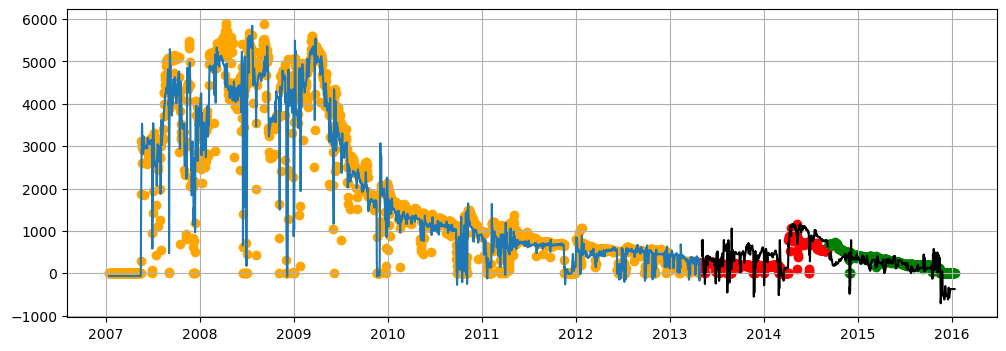

In [178]:
plt.figure(figsize=(12,4))

plt.scatter(adjusted_train_index , y_train_unscaled, color='orange')
plt.plot(adjusted_train_index , yp_train)

# plt.scatter(df.index[train_length+n_in:] , y_test, color='green')
# plt.plot(df.index[train_length+n_in:] , yp_test, color='black')

plt.scatter(adjusted_val_index, y_val_unscaled, color='red')
plt.plot(adjusted_val_index , yp_val, color='black')


plt.scatter(adjusted_test_index , y_test_unscaled, color='green')
plt.plot(adjusted_test_index , yp_test, color='black')

# plt.axvline(df.index[train_length+n_in], color='red')


plt.grid()

In [179]:
mse(yp_test, y_test_unscaled, squared=False)

229.0259794070853

In [180]:
joblib.dump(cnn_model, 'cnn_model_best.joblib')

INFO:tensorflow:Assets written to: C:\Users\abdul\AppData\Local\Temp\tmpbye2te8d\assets


INFO:tensorflow:Assets written to: C:\Users\abdul\AppData\Local\Temp\tmpbye2te8d\assets


['cnn_model_best.joblib']

In [181]:
cnn_model = joblib.load('cnn_model_best.joblib')

In [182]:
cnn_model.summary()

Model: "sequential_161"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_157 (Conv1D)         (None, 4, 128)            1920      
                                                                 
 flatten_157 (Flatten)       (None, 512)               0         
                                                                 
 dense_331 (Dense)           (None, 30)                15390     
                                                                 
 dense_332 (Dense)           (None, 1)                 31        
                                                                 
Total params: 17341 (67.74 KB)
Trainable params: 17341 (67.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
################################################################################################################################

### CNN-LSTM HYBRID

In [33]:
n_in = 5
n_out = 1




# Sequence creation
X_train = []
y_train = []
for i in range(n_in, len(train_X_scaled)):
    X_train.append(train_X_scaled[i-n_in:i, :])
    y_train.append(train_y_scaled[i:i+n_out, 0])
X_train, y_train = np.array(X_train), np.array(y_train)



X_val = []
y_val = []
for i in range(n_in, len(val_X_scaled)):
    X_val.append(val_X_scaled[i-n_in:i, :])
    y_val.append(val_y_scaled[i:i+n_out, 0])
X_val, y_val = np.array(X_val), np.array(y_val)



X_test = []
y_test = []
for i in range(n_in, len(test_X_scaled)):
    X_test.append(test_X_scaled[i-n_in:i, :])
    y_test.append(test_y_scaled[i:i+n_out, 0])
X_test, y_test = np.array(X_test), np.array(y_test)  

In [34]:
X_test.shape

(488, 5, 7)

Epoch 1/100
144/144 [==============================] - 8s 11ms/step - loss: 0.3859 - val_loss: 0.7510
Epoch 2/100
144/144 [==============================] - 1s 7ms/step - loss: 0.1465 - val_loss: 0.5497
Epoch 3/100
144/144 [==============================] - 1s 7ms/step - loss: 0.1334 - val_loss: 0.5696
Epoch 4/100
144/144 [==============================] - 1s 7ms/step - loss: 0.1340 - val_loss: 0.4951
Epoch 5/100
144/144 [==============================] - 1s 7ms/step - loss: 0.1226 - val_loss: 0.4556
Epoch 6/100
144/144 [==============================] - 1s 7ms/step - loss: 0.1247 - val_loss: 0.3902
Epoch 7/100
144/144 [==============================] - 1s 7ms/step - loss: 0.1132 - val_loss: 0.3275
Epoch 8/100
144/144 [==============================] - 1s 7ms/step - loss: 0.1147 - val_loss: 0.2725
Epoch 9/100
144/144 [==============================] - 1s 7ms/step - loss: 0.1094 - val_loss: 0.2301
Epoch 10/100
144/144 [==============================] - 1s 6ms/step - loss: 0.1064 - val_l

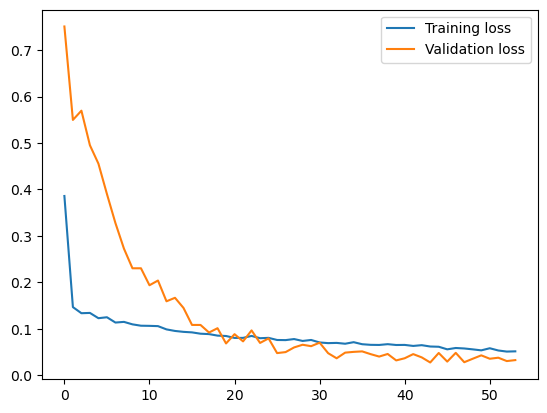

In [35]:
np.random.seed(42)
tf.random.set_seed(42)
hyb_model = Sequential()
hyb_model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(5, 7)))
hyb_model.add(MaxPooling1D(pool_size=2))
hyb_model.add(Flatten())
hyb_model.add(Reshape((1, -1)))
hyb_model.add(LSTM(32, activation='relu', return_sequences=True))
hyb_model.add(LSTM(64, activation='relu'))
# hyb_model.add(Dense(55, activation='relu'))
hyb_model.add(Dense(1))

# compile the model
hyb_model.compile(loss='mse', optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience = 10)
# early_stopping = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights=True)

history = hyb_model.fit(X_train, y_train, epochs=100,validation_data=(X_test,y_test),callbacks=[early_stopping], batch_size=16)
# history = cnn_model.fit(X_train, y_train, epochs=5, batch_size=64)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [36]:
yp_train = hyb_model.predict(X_train)
yp_test = hyb_model.predict(X_test)
yp_val = hyb_model.predict(X_val)

yp_train = target_scaler.inverse_transform(yp_train)
yp_test = target_scaler.inverse_transform(yp_test)


y_train =target_scaler.inverse_transform(y_train)
y_test = target_scaler.inverse_transform(y_test)



y_val =target_scaler.inverse_transform(y_val)
yp_val = target_scaler.inverse_transform(yp_val)

16/16 [==============================] - 0s 4ms/step


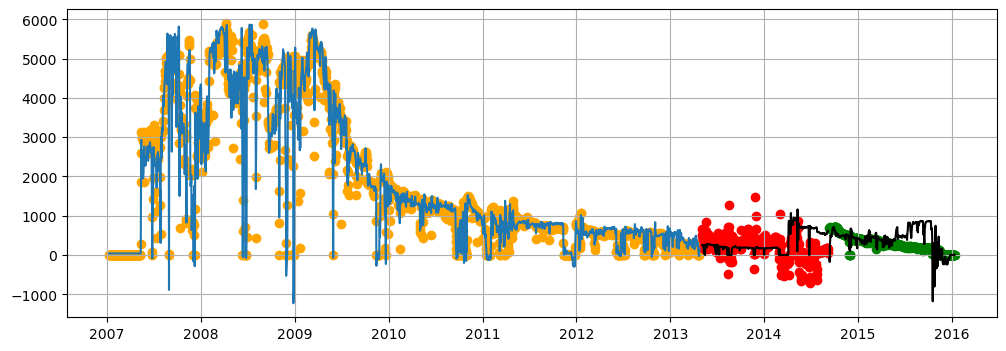

In [37]:
plt.figure(figsize=(12,4))

plt.scatter(df.index[:train_length-n_in] , y_train, color='orange')
plt.plot(df.index[:train_length-n_in] , yp_train)

# plt.scatter(df.index[train_length+n_in:] , y_test, color='green')
# plt.plot(df.index[train_length+n_in:] , yp_test, color='black')

plt.scatter(df.index[train_length+n_in:-test_length] , yp_val, color='red')
plt.plot(df.index[train_length+n_in:-test_length] , y_val, color='black')

plt.scatter(df.index[-test_length+n_in:] , y_test, color='green')
plt.plot(df.index[-test_length+n_in:] , yp_test, color='black')

# plt.axvline(df.index[train_length+n_in], color='red')


plt.grid()

In [38]:
mse(yp_test, y_test, squared=False)

316.4425733499494

In [29]:
n_in = 5
n_out = 1

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

random_seed = 60
tf.random.set_seed(random_seed)

while True:
    # Sequence creation
    X_train = []
    y_train = []
    for i in range(n_in, len(train_X_scaled)):
        X_train.append(train_X_scaled[i - n_in:i, :])
        y_train.append(train_y_scaled[i:i + n_out, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    X_val = []
    y_val = []
    for i in range(n_in, len(val_X_scaled)):
        X_val.append(val_X_scaled[i - n_in:i, :])
        y_val.append(val_y_scaled[i:i + n_out, 0])
    X_val, y_val = np.array(X_val), np.array(y_val)

    X_test = []
    y_test = []
    for i in range(n_in, len(test_X_scaled)):
        X_test.append(test_X_scaled[i - n_in:i, :])
        y_test.append(test_y_scaled[i:i + n_out, 0])
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Build and compile the model
    np.random.seed(42)
    tf.random.set_seed(42)
    
    hyb_model = Sequential()
    hyb_model.add(Conv1D(128, kernel_size=2, activation='relu', input_shape=(5, 7)))
    hyb_model.add(MaxPooling1D(pool_size=2))
    hyb_model.add(Flatten())
    hyb_model.add(Reshape((1, -1)))
    hyb_model.add(LSTM(16, activation='relu', return_sequences=True))
    hyb_model.add(LSTM(16 * 2, activation='relu'))
    hyb_model.add(Dense(32, activation='relu'))
    hyb_model.add(Dense(1))
    
    hyb_model.compile(loss='mse', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = hyb_model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                        callbacks=[early_stopping], batch_size=20, verbose=0)

    # Make predictions on test data and inverse transform
    yp_test = hyb_model.predict(X_test)
    yp_test = target_scaler.inverse_transform(yp_test)
    y_test = target_scaler.inverse_transform(y_test)

    # Calculate RMSE
    rmse_score = calculate_rmse(yp_test, y_test)

    print(f"RMSE score: {rmse_score}")

    # Check if RMSE is less than 200, if yes, break the loop
    if rmse_score < 200:
        break

print("Training completed with RMSE < 200.")


16/16 [==============================] - 30s 41ms/step
RMSE score: 810.7861245509202
16/16 [==============================] - 1s 5ms/step
RMSE score: 390.55514909076174
16/16 [==============================] - 1s 4ms/step
RMSE score: 481.28412559718
16/16 [==============================] - 1s 3ms/step
RMSE score: 675.1386347616937
16/16 [==============================] - 1s 3ms/step
RMSE score: 935.1271637907574
16/16 [==============================] - 1s 3ms/step
RMSE score: 532.4867070839854
16/16 [==============================] - 1s 3ms/step
RMSE score: 878.7025284194845
16/16 [==============================] - 1s 8ms/step
RMSE score: 807.9037541387809
16/16 [==============================] - 1s 3ms/step
RMSE score: 1024.1252034017873
16/16 [==============================] - 1s 3ms/step
RMSE score: 494.11947465877915
16/16 [==============================] - 1s 3ms/step
RMSE score: 655.412371492445
16/16 [==============================] - 1s 3ms/step
RMSE score: 923.1219609517099
16

In [53]:
yp_train = hyb_model.predict(X_train)
yp_test = hyb_model.predict(X_test)
yp_val = hyb_model.predict(X_val)

yp_train = target_scaler.inverse_transform(yp_train)
yp_test = target_scaler.inverse_transform(yp_test)


y_train =target_scaler.inverse_transform(y_train)
y_test = target_scaler.inverse_transform(y_test)



y_val =target_scaler.inverse_transform(y_val)
yp_val = target_scaler.inverse_transform(yp_val)

16/16 [==============================] - 0s 4ms/step


In [54]:
lookback = n_in

adjusted_train_index=df.iloc[lookback:train_length].index
adjusted_val_index=df.iloc[train_length+lookback:-test_length:].index
adjusted_test_index=df.iloc[-test_length+lookback:].index

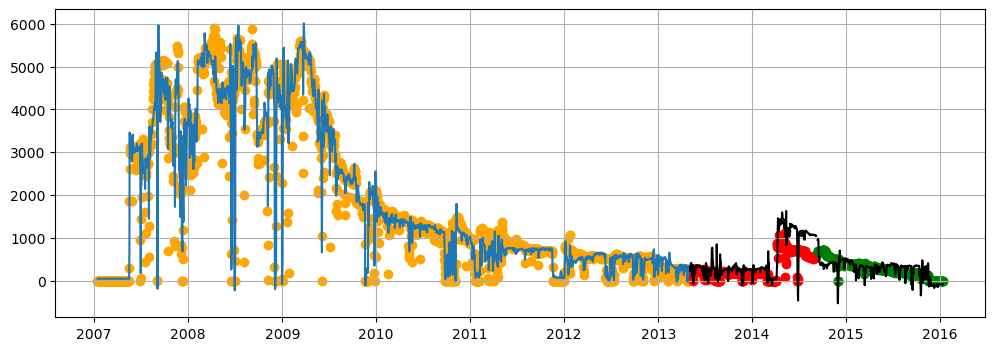

In [55]:
plt.figure(figsize=(12,4))

plt.scatter(adjusted_train_index , y_train, color='orange')
plt.plot(adjusted_train_index , yp_train)

# plt.scatter(df.index[train_length+n_in:] , y_test, color='green')
# plt.plot(df.index[train_length+n_in:] , yp_test, color='black')

plt.scatter(adjusted_val_index, y_val, color='red')
plt.plot(adjusted_val_index , yp_val, color='black')


plt.scatter(adjusted_test_index , y_test, color='green')
plt.plot(adjusted_test_index , yp_test, color='black')

# plt.axvline(df.index[train_length+n_in], color='red')


plt.grid()

In [56]:
mse(yp_test, y_test, squared = False)

154.5204404616256

In [58]:
joblib.dump(hyb_model, 'hybrid_model.joblib')

INFO:tensorflow:Assets written to: C:\Users\abdul\AppData\Local\Temp\tmplv399nnz\assets


INFO:tensorflow:Assets written to: C:\Users\abdul\AppData\Local\Temp\tmplv399nnz\assets


['hybrid_model.joblib']

In [59]:
hybrid_model = joblib.load('hybrid_model.joblib')

In [60]:
hybrid_model.summary()

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_81 (Conv1D)          (None, 4, 128)            1920      
                                                                 
 max_pooling1d_81 (MaxPooli  (None, 2, 128)            0         
 ng1D)                                                           
                                                                 
 flatten_81 (Flatten)        (None, 256)               0         
                                                                 
 reshape_81 (Reshape)        (None, 1, 256)            0         
                                                                 
 lstm_162 (LSTM)             (None, 1, 16)             17472     
                                                                 
 lstm_163 (LSTM)             (None, 32)                6272      
                                                     